# MICCoM School 2017 Ex#3 : The GW self-energy

We are going to dive into the GW calculation done in Exercise #1.

In this excercixe we will focus on the input for `wfreq.x`.

In [1]:
# download the pseudopotentials
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf

# download the input files
!wget -N -q http://www.west-code.org/doc/training/silane/pw.in
!wget -N -q http://www.west-code.org/doc/training/silane/wstat.in
!wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in

We need to read the output of a DFT calculation, therefore as first step we run the DFT calculation invoking the executable `pw.x` on 8 cores.

In [ ]:
!mpirun -n 8 pw.x -i pw.in > pw.out

We also need the dielectric matrix eigenpotentials in order to build G and W, therefore as second step we run the PDEP calculation invoking the executable `wstat.x` on 8 cores.

In [ ]:
!mpirun -n 8 wstat.x -i wstat.in > wstat.out

## 3.1 : Calculation of the GW self-energy

Let's give a quick look at the input for `wfreq.x` (description of the input variables for `wfreq.x` can be found here: http://www.west-code.org/doc/West/latest/manual.html#wfreq-control).

In [2]:
!cat wfreq.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0

The keywords "XWGQ" instruct the code to compute the exact exchange operator ("X"), the screened Coulomb operator ("W"), the Green's function ("G"), and the quasiparticle energies ("Q").

In this case we are using the 50 eigenpotentials $\phi_i$ obtained by `wstat.x`.

We are going to compute the GW energy of the states 1, 2, 3, 4 (HOMO), and 5 (LUMO). Remember that in this example (spin-unpolarized) each state can host two electrons.

The frequency cutoff controls the contour deformation integration.

Details about the implementation are described in [J. Chem. Theory Comput. 11, 2680 (2015)](https://pubs.acs.org/doi/full/10.1021/ct500958p#showFigures) :

<img src="https://pubs.acs.org/cms/10.1021/ct500958p/asset/images/medium/ct-2014-00958p_0007.gif" width="50%">

In [ ]:
!mpirun -n 8 wfreq.x -i wfreq.in > wfreq.out

We now load the output (JSON) of the `wfreq.x` calculation, which can be found in the `wfreq.save` folder.

In [3]:
import json

# read data from JSON file
with open('silane.wfreq.save/wfreq.json', 'r') as file:
    data = json.load(file)

# pretty print the data
print(json.dumps(data, indent=2))

{
  "runjob": {
    "startdate": "17Aug2022",
    "starttime": "11:49:24",
    "completed": true,
    "endtime": "11:49:53",
    "enddate": "17Aug2022"
  },
  "software": {
    "package": "WEST",
    "program": "WFREQ",
    "version": "5.0.0",
    "westgit": "v5.0.0-117-ga4764c0",
    "website": "http://www.west-code.org",
    "citation": "M. Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015).",
    "qeversion": "7.1"
  },
  "config": {
    "io": {
      "islittleendian": true
    }
  },
  "parallel": {
    "nranks": 2,
    "nimage": 1,
    "npool": 1,
    "nbgrp": 1,
    "nrg": 2,
    "nproc": 36,
    "nthreads": 18
  },
  "input": {
    "input_west": {
      "qe_prefix": "silane",
      "west_prefix": "silane",
      "outdir": "./"
    },
    "wstat_control": {
      "wstat_calculation": "S",
      "n_pdep_eigen": 50,
      "n_pdep_times": 4,
      "n_pdep_maxiter": 100,
      "n_dfpt_maxiter": 250,
      "n_pdep_read_from_file": 0,
      "n_steps_write_restart": 1,
      "trev_p

We plot the energy levels of DFT and GW.

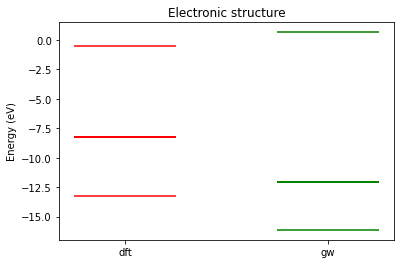

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# extracting energy levels from the data
y = {}
y['dft'] = data['output']['Q']['K000001']['eks']
y['gw']  = data['output']['Q']['K000001']['eqpSec']

# colors
c = {}
c['dft'] = 'red'
c['gw']  = 'green'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels)

plt.ylabel('Energy (eV)')
plt.title('Electronic structure')

plt.show()

Let's plot the density of states (DOS) of DFT and GW, obtained as a sum of Gaussian functions

\begin{equation}
\text{DOS}(E) = \sum_{i=1}^{N_{\text{states}}} \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(E-E_i)^2}{2\sigma^2}}
\end{equation}

We are going to set $\sigma=0.2eV$.

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2022-10-07 12:29:53.167016
Requested (emin,emax) :  -18.0 2.0
Detected  (emin,emax) :  -16.135751705765212 0.6646203810762062
output written in :  dos.png
waiting for user to close image preview...


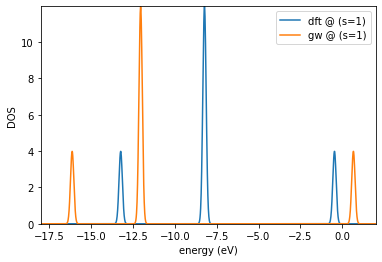

In [5]:
from westpy import *

es = ElectronicStructure()

for key in ['dft','gw'] :
    es.addKey(key,key)
    b = 0
    for energy in y[key] :
        es.addDataPoint([1,1,b+1],key,y[key][b])
        b += 1

es.plotDOS(kk=[1],ss=[1],energyKeys=['dft','gw'],energyRange=[-18.,2.,0.01],fname='dos.png')

## 5.2 : GW-full and GW-linear

The algorithms implemented in WEST make affordable the calculation of the quasiparticle equation self-consistently, which we can call **GW-full**

\begin{equation}
E^{\text{GW-full}}_n = \varepsilon^{\text{DFT}}_n + \left\langle \psi_n \right | \Sigma(E^{\text{GW-full}}_n) - V_{\text{xc}}\left| \psi_n \right\rangle
\end{equation}

However, in literature one often introduces a Taylor expansion of the self-energy $\Sigma$ around the DFT energy

\begin{equation}
\Sigma(E^{\text{QP}}_n) = \Sigma(\varepsilon^{\text{DFT}}_n) + \left.\frac{d\Sigma}{dE}\right|_{E=\varepsilon^{\text{DFT}}_n} (E^{\text{QP}}_n-\varepsilon^{\text{DFT}}_n)+\cdots
\end{equation}

In this way, called here **GW-linear**, operators can be evaluated one time at DFT energies only (no iteration is needed)

\begin{equation}
E^{\text{GW-linear}}_n = \varepsilon^{\text{DFT}}_n + Z_n \left\langle \psi_n \right | \Sigma(\varepsilon^{\text{DFT}}_n) - V_{\text{xc}}\left| \psi_n \right\rangle
\end{equation}

where $Z_n=\left(1-\left.\frac{d\Sigma}{dE}\right|_{E=\varepsilon^{\text{DFT}}_n}\right)^{-1}$.

WEST will always aim at computing **GW-full**, using a secant iteration scheme, however **GW-linear** is saved in output as it corresponds to the first iteration of the secant method.

We plot the energy levels of DFT and **GW-full** and **GW-linear**.

gw-lin : [-16.274079895237996, -12.152440223683891, -12.14867626806817, -12.147747634498469, 0.6657316496384642]
gw-full : [-16.135751705765212, -12.047981701915175, -12.044133556216615, -12.0431690105994, 0.6646203810762062]


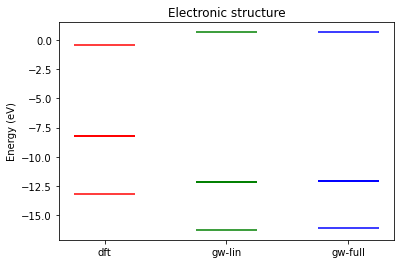

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# extracting energy levels from the data
y = {}
y['dft']     = data['output']['Q']['K000001']['eks']
y['gw-lin']  = data['output']['Q']['K000001']['eqpLin']
y['gw-full'] = data['output']['Q']['K000001']['eqpSec']

print('gw-lin :' , y['gw-lin'])
print('gw-full :', y['gw-full'])

# colors
c = {}
c['dft']     = 'red'
c['gw-lin']  = 'green'
c['gw-full'] = 'blue'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels)

plt.ylabel('Energy (eV)')
plt.title('Electronic structure')

plt.show()

**GW-linear** and **GW-full** give similar results. In order to understand why Taylor exapanding the self-energy $\Sigma$ around DFT energies, we redo the calculation turning on the runlevel `P`, which will compute $\Sigma(E)$ on a regular mesh of energies.

Let's add the part related to the plot of the self-energy in `wfreq.in`.

In [7]:
import yaml

# read data wfreq.in
with open('wfreq.in', 'r') as file:
    input_data = yaml.load(file, Loader=yaml.FullLoader)

# pretty print
print('input_data')
print(yaml.dump(input_data, sort_keys=False))

# modify the input_data
input_data['wfreq_control']['wfreq_calculation'] = 'XWGQP'
input_data['wfreq_control']['qp_bandrange'] = [4,5]
input_data['wfreq_control']['ecut_spectralf'] = [-1.5,0.5]
input_data['wfreq_control']['n_spectralf'] = 300

# write data to YAML file
with open('wfreq_P.in', 'w') as file:
    yaml.dump(input_data, file, sort_keys=False)

# show content of the file
print('wfreq_P.in')
!cat wfreq_P.in

input_data
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 50
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0

wfreq_P.in
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQP
  n_pdep_eigen_to_use: 50
  qp_bandrange:
  - 4
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
  ecut_spectralf:
  - -1.5
  - 0.5
  n_spectralf: 300


In [ ]:
!mpirun -n 8 wfreq.x -i wfreq_P.in > wfreq_P.out

We plot the self-energy.

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     1      |     -13.238     |     -16.275     |     -16.138    


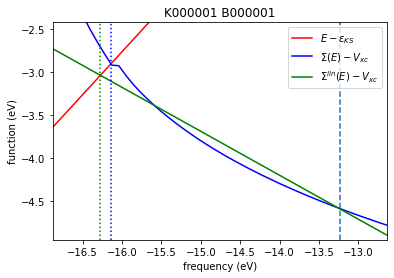

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     2      |     -8.232      |     -12.153     |     -12.048    


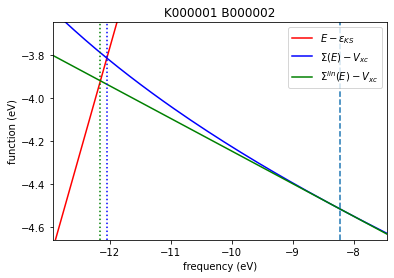

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     3      |     -8.232      |     -12.150     |     -12.045    


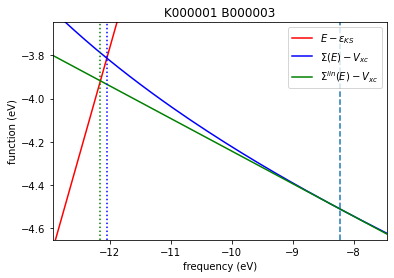

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     4      |     -8.231      |     -12.149     |     -12.044    


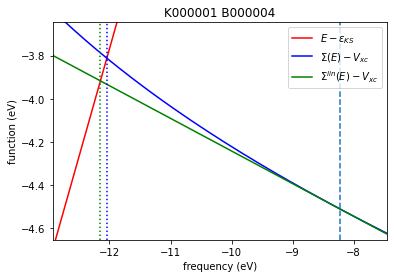

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     5      |     -0.466      |      0.665      |      0.664     


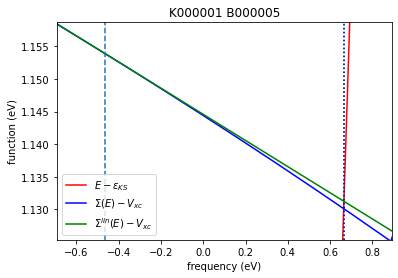

In [8]:
import json
import numpy as np

# Load the output data
with open('silane.wfreq.save/wfreq_P.json', 'r') as json_file:
    data = json.load(json_file)

# Extract converged quasiparticle (QP) corrections
k = 1
kindex = f'K{k:06d}'

bandmap = data['output']['Q']['bandmap']
eqp = data['output']['Q'][kindex]

freqlist = np.array(data['output']['P']['freqlist'], dtype='f8')
spf = data['output']['P'][kindex]

# Plot
import matplotlib.pyplot as plt

for i, b in enumerate(bandmap) :

    eks, eqpLin, eqpSec = eqp['eks'][i], eqp['eqpLin'][i], eqp['eqpSec'][i]

    # Print QP corrections
    print(f"{'k':^10} | {'band':^10} | {'eks [eV]':^15} | {'eqpLin [eV]':^15} | {'eqpSec [eV]':^15}")
    print(77*'-')
    print(f'{k:^10} | {b:^10} | {eks:^15.3f} | {eqpLin:^15.3f} | {eqpSec:^15.3f}')

    sigmax, vxcl, vxcnl = eqp['sigmax'][i], eqp['vxcl'][i], eqp['vxcnl'][i]
    sigmac_eks = eqp['sigmac_eks']['re'][i]
    sigmac_eqpLin = eqp['sigmac_eqpLin']['re'][i]
    sigmac_eqpSec = eqp['sigmac_eqpSec']['re'][i]
    z = eqp['z'][i]

    bindex = f'B{b:06d}'
    sigmac = np.array(spf[bindex]['sigmac']['re'], dtype='f8')

    # Left-hand side of QP equation
    plt.plot(freqlist,freqlist-eks,'r-',label=r'$E-\varepsilon_{KS}$')

    # Right-hand side of QP equation without linearization
    plt.plot(freqlist,sigmac+sigmax-vxcl-vxcnl,'b-',label=r'$\Sigma(E)-V_{xc}$')

    # Right-hand side of QP equation with linearization
    plt.plot(freqlist,sigmac_eks+sigmax-vxcl-vxcnl+(1-1/z)*(freqlist-eks),'g-',label=r'$\Sigma^{lin}(E)-V_{xc}$')

    plt.legend()
    plt.title(kindex+' '+bindex)
    plt.xlabel('frequency (eV)')
    plt.ylabel('function (eV)')
    xmin, xmax = min(eks, eqpLin, eqpSec), max(eks, eqpLin, eqpSec)
    ymin, ymax = min(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec), max(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec)
    ymin += sigmax - vxcl -vxcnl
    ymax += sigmax - vxcl -vxcnl
    plt.vlines(x=eks,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls='--')
    plt.vlines(x=eqpLin,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=':',color='g')
    plt.vlines(x=eqpSec,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=':',color='b')
    plt.xlim([xmin-0.2*(xmax-xmin),xmax+0.2*(xmax-xmin)])
    plt.ylim([ymin-0.2*(ymax-ymin),ymax+0.2*(ymax-ymin)])
    plt.show()

**Question**: *Why for SiH<sub>4</sub> GW-linear energies are lower than GW-full ones?*

## 5.3 : Convergence of GW with respect to npdep

The basis set used to represent the dielectric matrix needs to be converged. We have computed $50$ eigenpotentials. We can now use *fewer* eigenpotentials in GW and test the convergece.

Let's prepare the input for 5 calculations done with 10, 20, 30, 40, 50 eigenpotentials. We will also stash the output file for later comparison.

In [9]:
import yaml

# we need to create 5 files, each with a different value of the variable n_pdep_eigen_to_use
for npdep in [10, 20, 30, 40, 50] :

    # read data wfreq.in
    with open('wfreq.in', 'r') as file:
        input_data = yaml.load(file, Loader=yaml.FullLoader)

    # modify the input_data
    input_data['wfreq_control']['n_pdep_eigen_to_use'] = npdep

    # write data to YAML file
    with open('wfreq_'+str(npdep)+'.in', 'w') as file:
        yaml.dump(input_data, file, sort_keys=False)

In [10]:
# give a quick look
!cat wfreq_10.in
!cat wfreq_20.in
!cat wfreq_30.in
!cat wfreq_40.in
!cat wfreq_50.in

input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 10
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 20
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 30
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 40
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  e

In [ ]:
# run them all and stash the output

!mpirun -n 8 wfreq.x -i wfreq_10.in > wfreq_10.out
!mv silane.wfreq.save/wfreq.json wfreq_10.json

!mpirun -n 8 wfreq.x -i wfreq_20.in > wfreq_20.out
!mv silane.wfreq.save/wfreq.json wfreq_20.json

!mpirun -n 8 wfreq.x -i wfreq_30.in > wfreq_30.out
!mv silane.wfreq.save/wfreq.json wfreq_30.json

!mpirun -n 8 wfreq.x -i wfreq_40.in > wfreq_40.out
!mv silane.wfreq.save/wfreq.json wfreq_40.json

!mpirun -n 8 wfreq.x -i wfreq_50.in > wfreq_50.out
!mv silane.wfreq.save/wfreq.json wfreq_50.json

In [11]:
!ls -lrt wfreq_*json

-rw-r--r--  1 vwzyu  staff  19408 Oct  7 12:41 wfreq_10.json
-rw-r--r--  1 vwzyu  staff  19406 Oct  7 12:41 wfreq_20.json
-rw-r--r--  1 vwzyu  staff  19423 Oct  7 12:41 wfreq_30.json
-rw-r--r--  1 vwzyu  staff  19417 Oct  7 12:41 wfreq_40.json
-rw-r--r--  1 vwzyu  staff  19408 Oct  7 12:41 wfreq_50.json


Load the files.

In [12]:
import json

data = {}

for npdep in [10, 20, 30, 40, 50] :

    # read data wfreq_XX.json
    with open('wfreq_'+str(npdep)+'.json', 'r') as file:
        data[npdep] = json.load(file)

print(json.dumps(data, indent=2))

{
  "10": {
    "runjob": {
      "startdate": " 7Oct2022",
      "starttime": "12:35:58",
      "completed": true,
      "endtime": "12:36: 2",
      "enddate": " 7Oct2022"
    },
    "software": {
      "package": "WEST",
      "program": "WFREQ",
      "version": "5.2.0",
      "westgit": "v5.2.0-4-ga2c3fe0",
      "website": "http://www.west-code.org",
      "citation": "M. Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015).",
      "qeversion": "7.1"
    },
    "config": {
      "io": {
        "islittleendian": true
      }
    },
    "parallel": {
      "nranks": 4,
      "nimage": 1,
      "npool": 1,
      "nbgrp": 1,
      "nrg": 4,
      "nproc": 4,
      "nthreads": 1
    },
    "input": {
      "input_west": {
        "qe_prefix": "silane",
        "west_prefix": "silane",
        "outdir": "./"
      },
      "wstat_control": {
        "wstat_calculation": "S",
        "n_pdep_eigen": 50,
        "n_pdep_times": 4,
        "n_pdep_maxiter": 100,
        "n_dfpt_maxite

We plot the energy levels of DFT and GW.

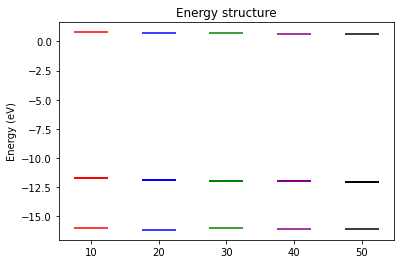

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# energy levels
y = {}
y[10] = data[10]['output']['Q']['K000001']['eqpSec']
y[20] = data[20]['output']['Q']['K000001']['eqpSec']
y[30] = data[30]['output']['Q']['K000001']['eqpSec']
y[40] = data[40]['output']['Q']['K000001']['eqpSec']
y[50] = data[50]['output']['Q']['K000001']['eqpSec']

# colors
c = {}
c[10] = 'red'
c[20] = 'blue'
c[30] = 'green'
c[40] = 'purple'
c[50] = 'black'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

#plt.ylim([-13,-11])

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')

plt.title('Energy structure')

plt.show()